# Similarity using a new generator trained on en-face Freddie Mercuries

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt


from lightweight_gan import LightweightGAN
import torch
import numpy as np

from PIL import Image
from torchvision.transforms import v2
from torchvision.utils import save_image

from glob import glob


MODEL_PATH = Path("model/model_174.pt")
LATENT_DIM = 256
IMG_SIZE = 256

TARGET_IMG_PATHS = sorted(glob("./img/target/aligned/*"))
UNALIGNED_IMG_PATHS = sorted(glob("./img/target/unaligned/*"))

torch.manual_seed(2048)

In [2]:
import os
import sys
import errno

from urllib.parse import urlparse
from torch.hub import download_url_to_file, HASH_REGEX
try:
    from torch.hub import get_dir
except BaseException:
    from torch.hub import _get_torch_home as get_dir
    
two_d_model_url = "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip"

def load_file_from_url(url, model_dir=None, progress=True, check_hash=False, file_name=None):
    if model_dir is None:
        hub_dir = get_dir()
        model_dir = os.path.join(hub_dir, 'checkpoints')

    try:
        os.makedirs(model_dir)
    except OSError as e:
        if e.errno == errno.EEXIST:
            # Directory already exists, ignore.
            pass
        else:
            # Unexpected OSError, re-raise.
            raise

    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if file_name is not None:
        filename = file_name
    cached_file = os.path.join(model_dir, filename)
    if not os.path.exists(cached_file):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
        hash_prefix = None
        if check_hash:
            r = HASH_REGEX.search(filename)  # r is Optional[Match[str]]
            hash_prefix = r.group(1) if r else None
        download_url_to_file(url, cached_file, hash_prefix, progress=progress)

    return cached_file


def load_landmarks_model():
    return torch.jit.load(load_file_from_url(two_d_model_url)).to("cuda:0").eval()

landmarks_model = load_landmarks_model()

In [8]:
def softargmax2d(input, beta=100):
    *_, w, h = input.shape

    input = input.reshape(*_, w * h)
    input = torch.nn.functional.softmax(beta * input, dim=-1)

    indices_c, indices_r = np.meshgrid(
        np.linspace(0, 1, w),
        np.linspace(0, 1, h),
        indexing='xy'
    )

    indices_r = torch.tensor(np.reshape(indices_r, (-1, h * w))).to("cuda:0")
    indices_c = torch.tensor(np.reshape(indices_c, (-1, h * w))).to("cuda:0")

    result_r = torch.sum((h - 1) * input * indices_r, dim=-1)
    result_c = torch.sum((w - 1) * input * indices_c, dim=-1)

    result = torch.stack([result_c, result_r], dim=-1)

    return result


def show_simple_landmarks(image: torch.Tensor) -> np.ndarray:
    return softargmax2d(landmarks_model(image.unsqueeze(0))).squeeze(0).detach().cpu().numpy()

In [4]:
def prep_tensor_to_show(tensor):
    return tensor.permute(1, 2, 0).detach().to('cpu').numpy()

def show_tensor_picture(tensor, title=""):
    im_arr = prep_tensor_to_show(tensor)
    plt.title(title)
    plt.axis("off")
    plt.imshow(im_arr)


def import_generator(model_filepath: Path) -> torch.nn.Module:
    model = torch.load(model_filepath)
    
    gan = LightweightGAN(latent_dim=LATENT_DIM,
                         image_size=IMG_SIZE, 
                         attn_res_layers=[32],
                         freq_chan_attn=False)
    gan.load_state_dict(model["GAN"], strict=False)
    gan.eval()
    gan.G.eval()

    return gan.G


def load_pickle_generator() -> torch.nn.Module:
    GENERATOR_PICKLE_PATH = Path("../z-to-param/model/generator.pt")
    return torch.load(GENERATOR_PICKLE_PATH)

def prep_image(filename)-> torch.tensor:
    image = Image.open(filename).convert("RGB")
    image_min_size = min(image.size)
    transforms = v2.Compose([
        v2.ToImage(),
        v2.CenterCrop(image_min_size),
        v2.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        v2.ToDtype(torch.float32, scale=True)
    ])
    return transforms(image).cuda(0)


def plot_images(images, labels, nrows, ncols, step=1, title="", figsize=[8, 4]):
    """Plot nrows x ncols images from images and set labels as titles."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        idx = i * step
        if images[i].shape[-1] == 1:
            ax.imshow((images[i]).reshape(images[idx].shape[0], images[idx].shape[1]))
        else:
            ax.imshow((images[idx]))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[idx])
    fig.suptitle(title)
    plt.tight_layout()
    # plt.savefig(f"{title}.png")
    plt.show()
    
def plot_loss(losses, iterations, title=""):
    plt.plot(iterations, losses)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.ylim(bottom=0, top=1.1*max(losses))
    # plt.savefig(f"{title}.png")
    plt.show()
    
    
def present_results(z, checkpoints, losses, original_image, lr=1e-4, iter=1000, number=0):
    generator = import_generator(MODEL_PATH)
    plot_images([checkpoint for _, checkpoint in checkpoints],
            [f"iteration {checkpoint_n}" for checkpoint_n, _ in checkpoints],
            nrows=len(checkpoints)//5, ncols=5,
            title=f"img/generated/generated_images_{lr}_{iter}_{number}", figsize=[8, 6])
    
    original_middle_image = prep_tensor_to_show(original_image)
    inffered_middle_image = prep_tensor_to_show(generator(z)[0])
    plot_images([original_middle_image, inffered_middle_image],
            ["original", "inferred"], 
            nrows=1, ncols=2,
            title=f"img/generated/original_vs_inferred_{lr}_{iter}_{number}", figsize=[8, 4])
    
    iterations = [i for i, _ in checkpoints]
    plot_loss(losses, iterations, title=f"img/plots/losses_{lr}_{iter}_{number}")

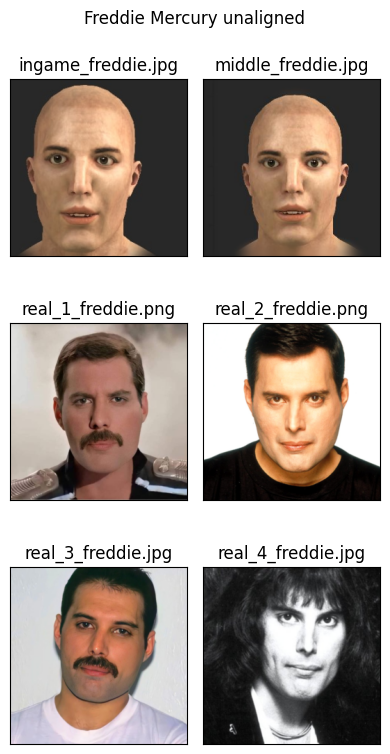

In [5]:
plot_images([prep_tensor_to_show(img) for img in [prep_image(p) for p in UNALIGNED_IMG_PATHS]],
            [p.split("/")[-1] for p in UNALIGNED_IMG_PATHS],
            3, 2, title="Freddie Mercury unaligned", figsize=[4, 8])

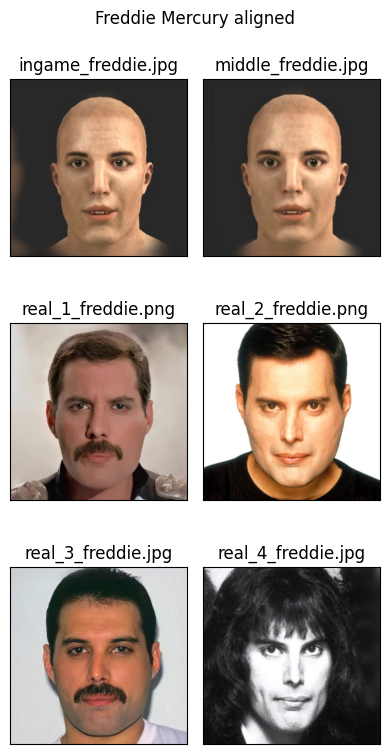

In [6]:
plot_images([prep_tensor_to_show(img) for img in [prep_image(p) for p in TARGET_IMG_PATHS]],
            [p.split("/")[-1] for p in UNALIGNED_IMG_PATHS],
            3, 2, title="Freddie Mercury aligned", figsize=[4, 8])

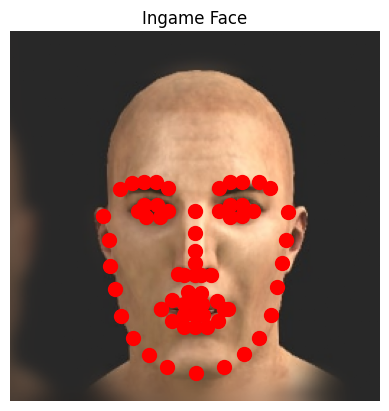

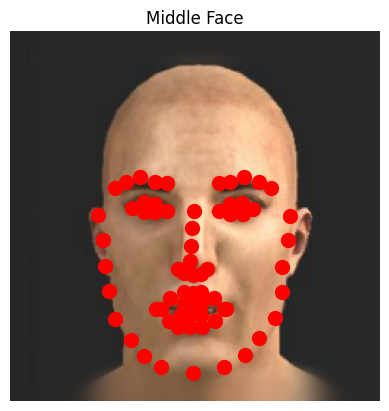

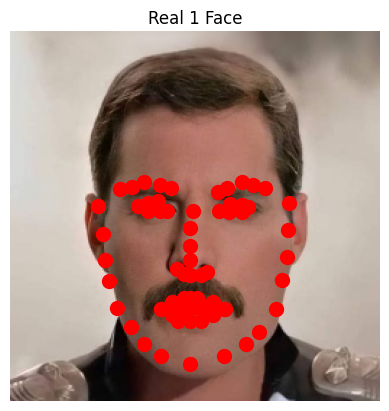

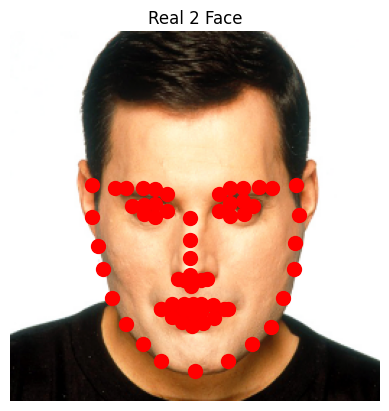

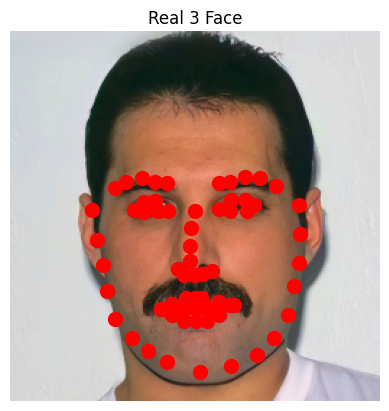

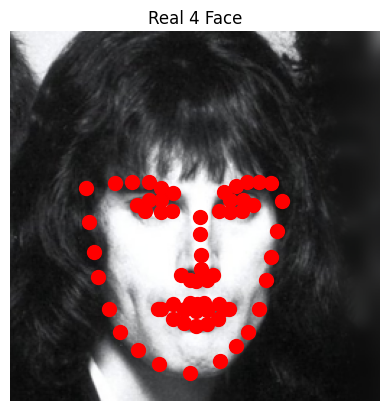

In [9]:
aligned_images = [prep_image(p) for p in TARGET_IMG_PATHS]

# Show faces with landmarks
#Potential problem - landmarks are 4 x smaller than they should be
for image, adj in zip(aligned_images, ("Ingame", "Middle", "Real 1", "Real 2", "Real 3", "Real 4")):
    landmarks = show_simple_landmarks(image)
    show_tensor_picture(image, title=f"{adj} Face")
    plt.scatter(4*landmarks[:, 0], 4*landmarks[:, 1], c='r', marker='.', s=400)
    plt.show()


## Generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


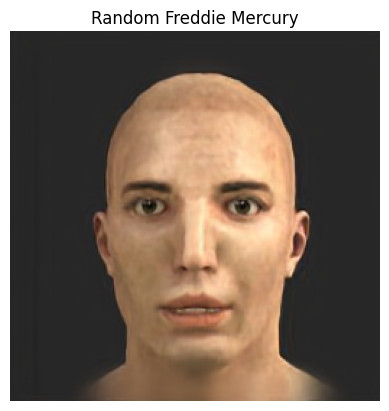

In [8]:
# generator = import_generator(MODEL_PATH)
generator = load_pickle_generator()

random_latent_vectors = torch.randn( (1, LATENT_DIM) ).cuda(0)
generated_images = generator(random_latent_vectors)
show_tensor_picture(generated_images[0], title="Random Freddie Mercury")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


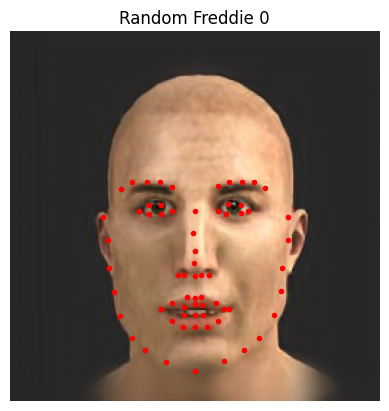

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


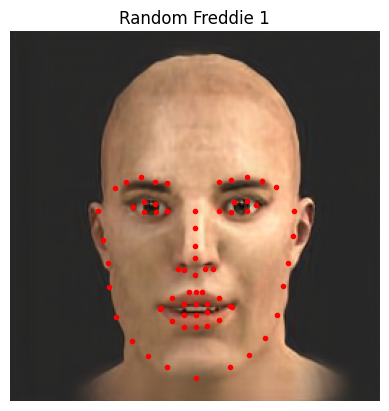

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


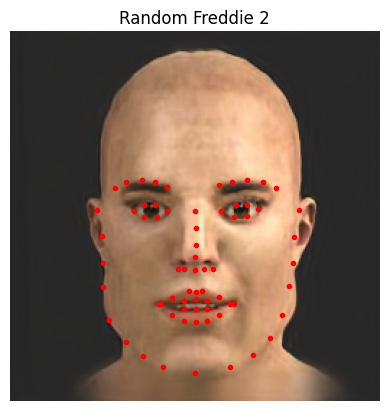

In [9]:
ten_random_z = torch.randn( (3, LATENT_DIM) ).cuda(0)
random_freddies = generator(ten_random_z)

for i, img in enumerate(random_freddies):
    landmarks = show_simple_landmarks(img)
    show_tensor_picture(img, title=f"Random Freddie {i}")
    plt.scatter(4*landmarks[:, 0], 4*landmarks[:, 1], c='r', marker='.')
    plt.show()
    


In [12]:
class DifferentiableLandmarks(torch.nn.Module):
    def __init__(self, generator, landmarks_model):
        super().__init__()
        self.z = torch.nn.Parameter(torch.randn( (1, LATENT_DIM), requires_grad=True, device="cuda"))
        
        self.landmarks_model = landmarks_model
        self.generator = generator
        self.generator.eval()
        self.landmarks_model.eval()
        
        for p in self.generator.parameters():
            p.requires_grad = False
            
        for p in self.landmarks_model.parameters():
            p.requires_grad = False
        
        
    def forward(self):
        return self.landmarks_model(self.generator(self.z))
    
    def get_z(self):
        return self.z.clone().detach()
    
    def print_are_training(self):
        print("Are training:")
        print(f"Generator: {self.generator.training}")
        print(f"Landmarks: {self.landmarks_model.training}")
        print(f"Model: {self.training}")
        
 
 
def find_z(image: torch.Tensor, lr=1e-3, iters=250) -> torch.Tensor:   
    generator = import_generator(MODEL_PATH).to("cuda:0")
    landmarks_model = load_landmarks_model()

    model = DifferentiableLandmarks(generator, landmarks_model)
    checkpoint_every = iters // 10

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    y_target = landmarks_model(image.unsqueeze(0)).detach()
    
    checkpoints = []
    landmark_checkpoints = []
    losses = []
    for i in range(iters):
        y_pred = model()
        loss = criterion(y_target, y_pred)
        if i % checkpoint_every  == 0:
            checkpoints.append((i, model.generator(model.z)[0].detach().permute((1,2,0)).cpu().numpy()))
            landmark_checkpoints.append((i, softargmax2d(y_pred[0]).detach().cpu().numpy()))
            losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Iteration: {i}, loss: {loss.item():.2E}")


    
    return  model.get_z(), checkpoints, losses

In [13]:
middle_image = prep_image(TARGET_IMG_PATHS[1])

middle_z, middle_checkpoints, middle_losses = find_z(middle_image)

Iteration: 0, loss: 3.53E-04
Iteration: 1, loss: 3.47E-04
Iteration: 2, loss: 3.42E-04
Iteration: 3, loss: 3.36E-04
Iteration: 4, loss: 3.30E-04
Iteration: 5, loss: 3.24E-04
Iteration: 6, loss: 3.18E-04
Iteration: 7, loss: 3.12E-04
Iteration: 8, loss: 3.07E-04
Iteration: 9, loss: 3.03E-04
Iteration: 10, loss: 2.98E-04
Iteration: 11, loss: 2.93E-04
Iteration: 12, loss: 2.89E-04
Iteration: 13, loss: 2.85E-04
Iteration: 14, loss: 2.81E-04
Iteration: 15, loss: 2.77E-04
Iteration: 16, loss: 2.72E-04
Iteration: 17, loss: 2.67E-04
Iteration: 18, loss: 2.62E-04
Iteration: 19, loss: 2.56E-04
Iteration: 20, loss: 2.51E-04
Iteration: 21, loss: 2.46E-04
Iteration: 22, loss: 2.40E-04
Iteration: 23, loss: 2.34E-04
Iteration: 24, loss: 2.28E-04
Iteration: 25, loss: 2.24E-04
Iteration: 26, loss: 2.20E-04
Iteration: 27, loss: 2.15E-04
Iteration: 28, loss: 2.10E-04
Iteration: 29, loss: 2.04E-04
Iteration: 30, loss: 1.99E-04
Iteration: 31, loss: 1.94E-04
Iteration: 32, loss: 1.88E-04
Iteration: 33, loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

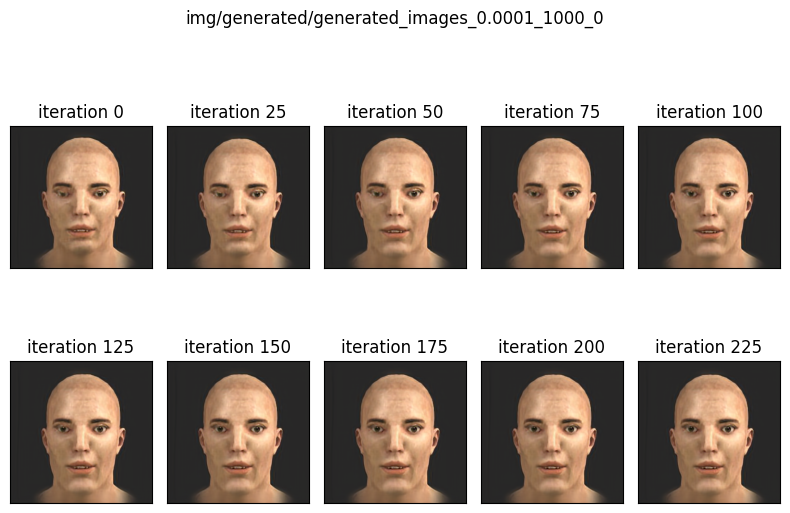

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


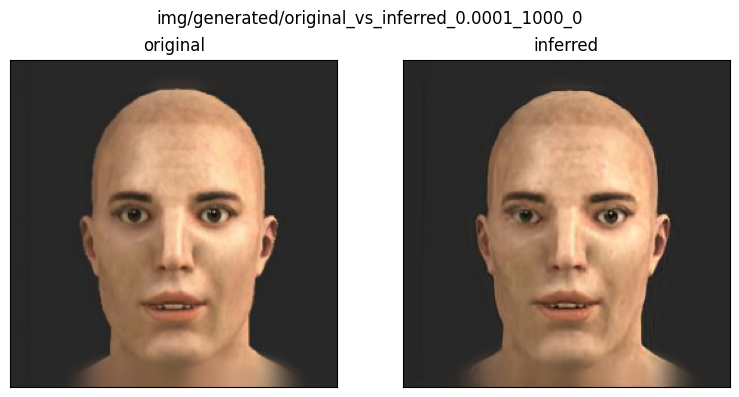

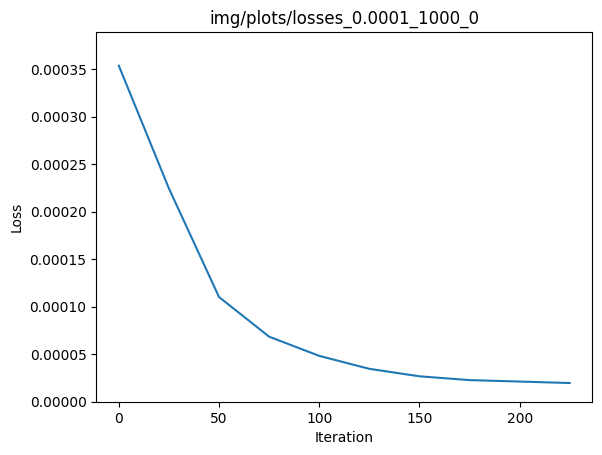

In [14]:
present_results(middle_z, middle_checkpoints, middle_losses, middle_image)

# plot_images([prep_tensor_to_show(generator(middle_z)[0]), prep_tensor_to_show(middle_image)], ["Generated", "Middle"], 1, 2, title="Generated and middle image")


Iteration: 0, loss: 2.01E-04
Iteration: 1, loss: 2.01E-04
Iteration: 2, loss: 1.98E-04
Iteration: 3, loss: 1.97E-04
Iteration: 4, loss: 1.96E-04
Iteration: 5, loss: 1.95E-04
Iteration: 6, loss: 1.93E-04
Iteration: 7, loss: 1.92E-04
Iteration: 8, loss: 1.91E-04
Iteration: 9, loss: 1.90E-04
Iteration: 10, loss: 1.88E-04
Iteration: 11, loss: 1.87E-04
Iteration: 12, loss: 1.86E-04
Iteration: 13, loss: 1.84E-04
Iteration: 14, loss: 1.83E-04
Iteration: 15, loss: 1.81E-04
Iteration: 16, loss: 1.79E-04
Iteration: 17, loss: 1.78E-04
Iteration: 18, loss: 1.76E-04
Iteration: 19, loss: 1.74E-04
Iteration: 20, loss: 1.72E-04
Iteration: 21, loss: 1.70E-04
Iteration: 22, loss: 1.69E-04
Iteration: 23, loss: 1.66E-04
Iteration: 24, loss: 1.65E-04
Iteration: 25, loss: 1.63E-04
Iteration: 26, loss: 1.62E-04
Iteration: 27, loss: 1.60E-04
Iteration: 28, loss: 1.59E-04
Iteration: 29, loss: 1.57E-04
Iteration: 30, loss: 1.57E-04
Iteration: 31, loss: 1.54E-04
Iteration: 32, loss: 1.53E-04
Iteration: 33, loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

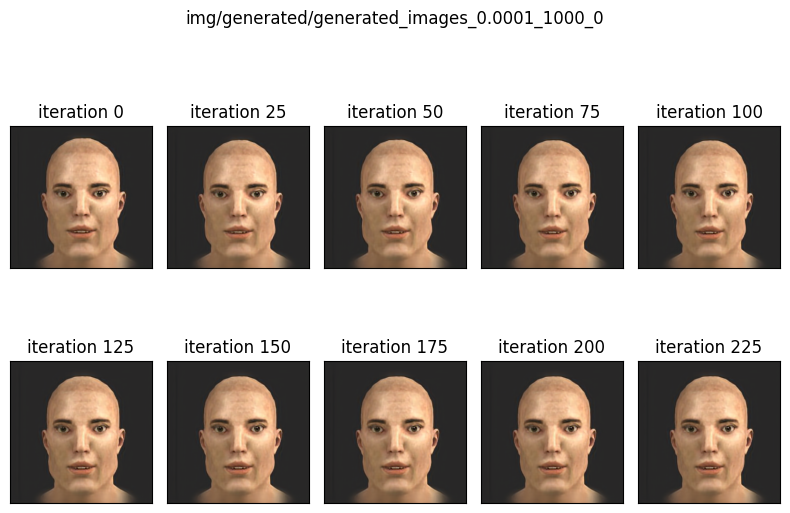

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


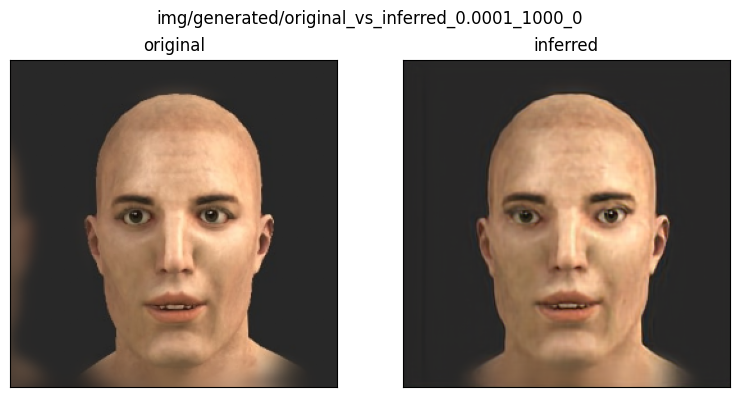

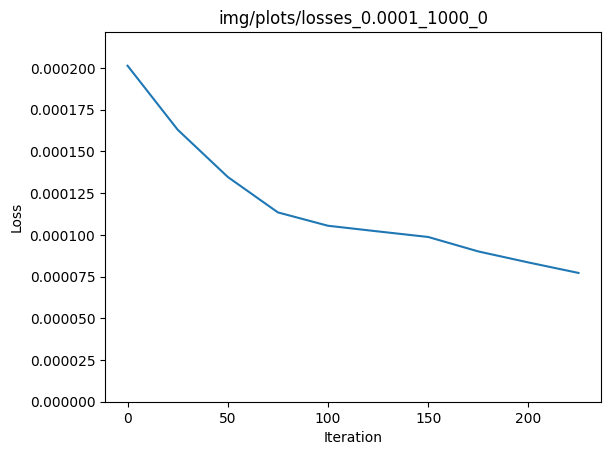

In [15]:
ingame_image = prep_image(TARGET_IMG_PATHS[0])

ingame_z, ingame_checkpoints, ingame_losses = find_z(ingame_image, lr=1e-3, iters=250)

present_results(ingame_z, ingame_checkpoints, ingame_losses, ingame_image)

Iteration: 0, loss: 1.82E-04
Iteration: 1, loss: 1.82E-04
Iteration: 2, loss: 1.80E-04
Iteration: 3, loss: 1.79E-04
Iteration: 4, loss: 1.78E-04
Iteration: 5, loss: 1.76E-04
Iteration: 6, loss: 1.75E-04
Iteration: 7, loss: 1.74E-04
Iteration: 8, loss: 1.72E-04
Iteration: 9, loss: 1.71E-04
Iteration: 10, loss: 1.69E-04
Iteration: 11, loss: 1.68E-04
Iteration: 12, loss: 1.67E-04
Iteration: 13, loss: 1.65E-04
Iteration: 14, loss: 1.64E-04
Iteration: 15, loss: 1.62E-04
Iteration: 16, loss: 1.61E-04
Iteration: 17, loss: 1.59E-04
Iteration: 18, loss: 1.58E-04
Iteration: 19, loss: 1.56E-04
Iteration: 20, loss: 1.55E-04
Iteration: 21, loss: 1.53E-04
Iteration: 22, loss: 1.53E-04
Iteration: 23, loss: 1.51E-04
Iteration: 24, loss: 1.50E-04
Iteration: 25, loss: 1.49E-04
Iteration: 26, loss: 1.47E-04
Iteration: 27, loss: 1.47E-04
Iteration: 28, loss: 1.46E-04
Iteration: 29, loss: 1.45E-04
Iteration: 30, loss: 1.44E-04
Iteration: 31, loss: 1.42E-04
Iteration: 32, loss: 1.42E-04
Iteration: 33, loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

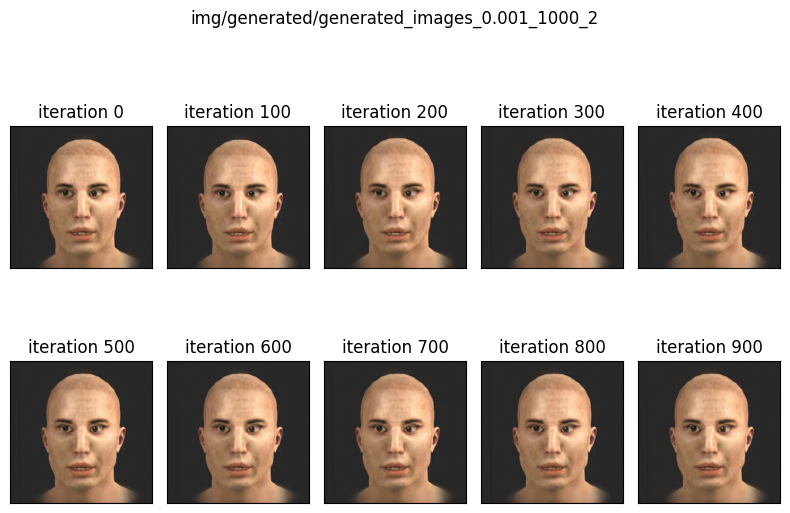

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


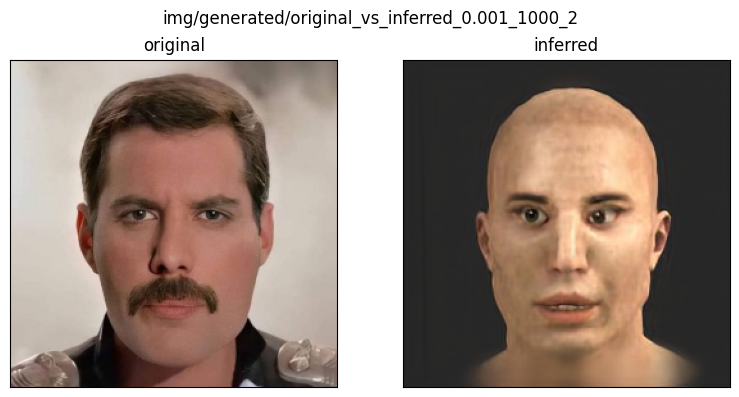

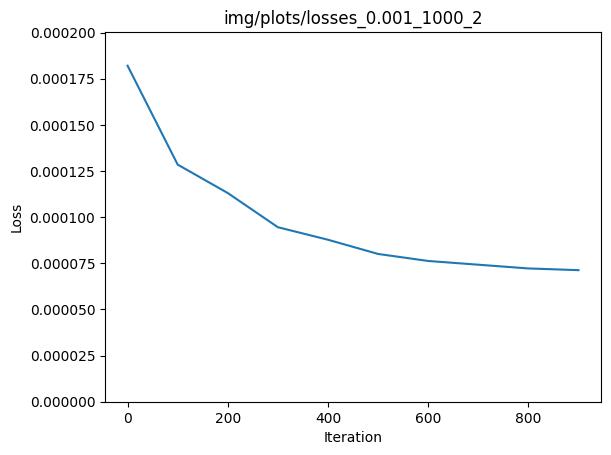

In [16]:
real_freddie_image = prep_image(TARGET_IMG_PATHS[2])

real_z, real_checkpoints, real_losses = find_z(real_freddie_image, lr=1e-3, iters=1000)

present_results(real_z, real_checkpoints, real_losses, real_freddie_image, lr=1e-3, iter=1000, number=2)

Iteration: 0, loss: 8.47E-04
Iteration: 1, loss: 8.45E-04
Iteration: 2, loss: 8.43E-04
Iteration: 3, loss: 8.42E-04
Iteration: 4, loss: 8.40E-04
Iteration: 5, loss: 8.38E-04
Iteration: 6, loss: 8.37E-04
Iteration: 7, loss: 8.35E-04
Iteration: 8, loss: 8.34E-04
Iteration: 9, loss: 8.32E-04
Iteration: 10, loss: 8.31E-04
Iteration: 11, loss: 8.29E-04
Iteration: 12, loss: 8.27E-04
Iteration: 13, loss: 8.24E-04
Iteration: 14, loss: 8.21E-04
Iteration: 15, loss: 8.18E-04
Iteration: 16, loss: 8.15E-04
Iteration: 17, loss: 8.12E-04
Iteration: 18, loss: 8.09E-04
Iteration: 19, loss: 8.06E-04
Iteration: 20, loss: 8.03E-04
Iteration: 21, loss: 8.02E-04
Iteration: 22, loss: 8.00E-04
Iteration: 23, loss: 7.99E-04
Iteration: 24, loss: 7.98E-04
Iteration: 25, loss: 7.96E-04
Iteration: 26, loss: 7.95E-04
Iteration: 27, loss: 7.93E-04
Iteration: 28, loss: 7.91E-04
Iteration: 29, loss: 7.90E-04
Iteration: 30, loss: 7.87E-04
Iteration: 31, loss: 7.86E-04
Iteration: 32, loss: 7.83E-04
Iteration: 33, loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

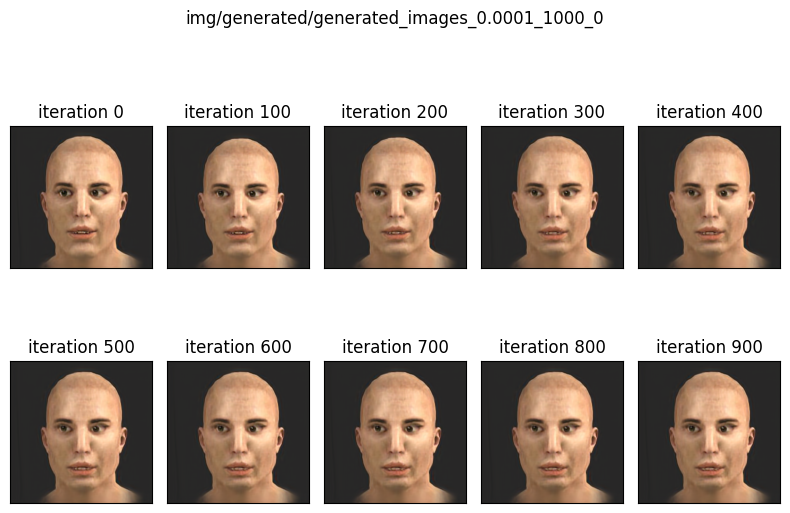

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


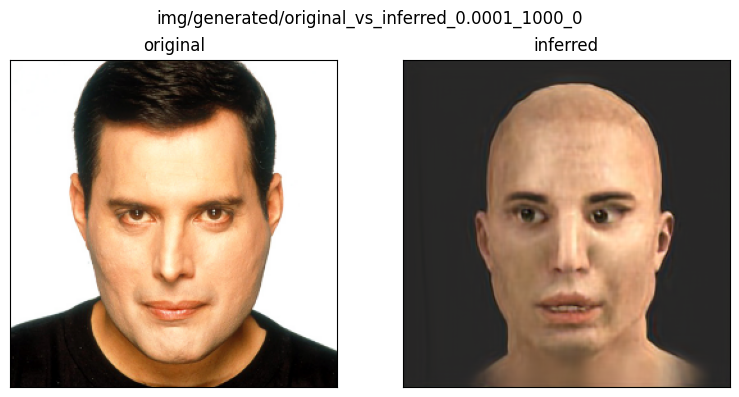

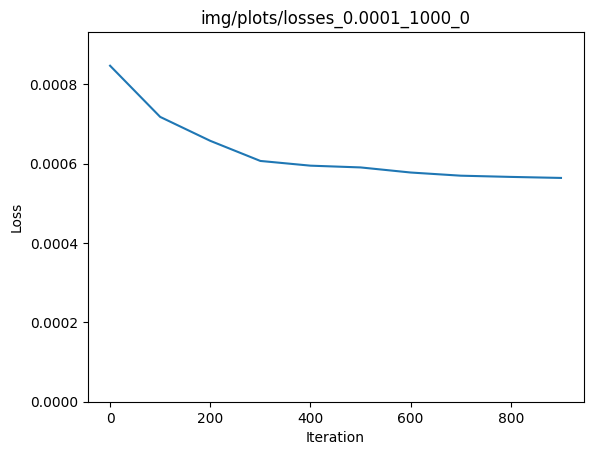

In [17]:
real_freddie_image = prep_image(TARGET_IMG_PATHS[3])

real_z, real_checkpoints, real_losses = find_z(real_freddie_image, lr=1e-3, iters=1000)

present_results(real_z, real_checkpoints, real_losses, real_freddie_image)

Iteration: 0, loss: 3.13E-04
Iteration: 1, loss: 3.12E-04
Iteration: 2, loss: 3.10E-04
Iteration: 3, loss: 3.09E-04
Iteration: 4, loss: 3.08E-04
Iteration: 5, loss: 3.07E-04
Iteration: 6, loss: 3.06E-04
Iteration: 7, loss: 3.05E-04
Iteration: 8, loss: 3.04E-04
Iteration: 9, loss: 3.03E-04
Iteration: 10, loss: 3.02E-04
Iteration: 11, loss: 3.01E-04
Iteration: 12, loss: 3.00E-04
Iteration: 13, loss: 2.99E-04
Iteration: 14, loss: 2.98E-04
Iteration: 15, loss: 2.96E-04
Iteration: 16, loss: 2.95E-04
Iteration: 17, loss: 2.94E-04
Iteration: 18, loss: 2.94E-04
Iteration: 19, loss: 2.93E-04
Iteration: 20, loss: 2.92E-04
Iteration: 21, loss: 2.91E-04
Iteration: 22, loss: 2.90E-04
Iteration: 23, loss: 2.90E-04
Iteration: 24, loss: 2.89E-04
Iteration: 25, loss: 2.87E-04
Iteration: 26, loss: 2.87E-04
Iteration: 27, loss: 2.86E-04
Iteration: 28, loss: 2.84E-04
Iteration: 29, loss: 2.82E-04
Iteration: 30, loss: 2.80E-04
Iteration: 31, loss: 2.78E-04
Iteration: 32, loss: 2.76E-04
Iteration: 33, loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

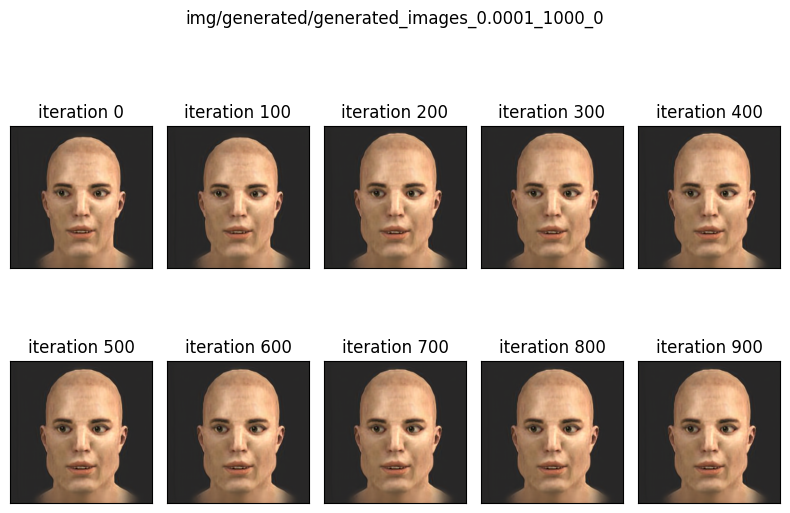

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


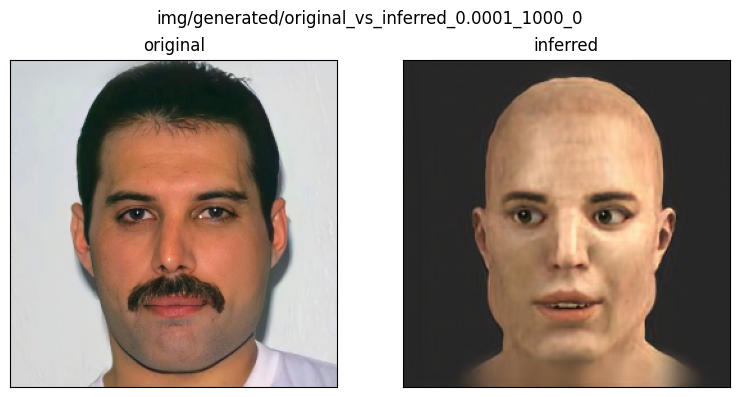

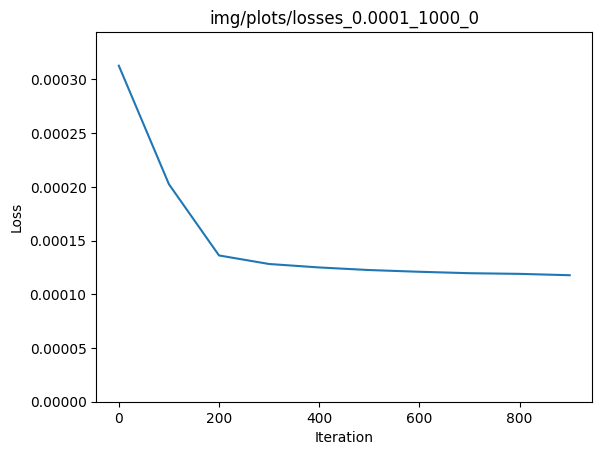

In [30]:
real_freddie_image = prep_image(TARGET_IMG_PATHS[4])

real_z, real_checkpoints, real_losses = find_z(real_freddie_image, lr=1e-3, iters=1000)

present_results(real_z, real_checkpoints, real_losses, real_freddie_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


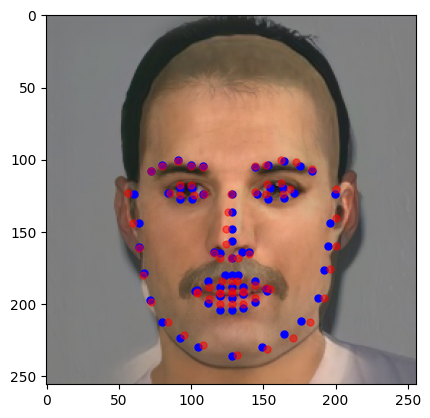

In [37]:
original_real_image = prep_tensor_to_show(real_freddie_image)
landmarks_original = show_simple_landmarks(real_freddie_image)
generated_real_image = generator(real_z)[0]
infered_real_image = prep_tensor_to_show(generated_real_image)
landmarks_infered = show_simple_landmarks(generated_real_image)

plt.imshow(infered_real_image)
plt.scatter(4*landmarks_infered[:, 0], 4*landmarks_infered[:, 1], c='b', marker='.', s=100)
plt.imshow(original_real_image,  alpha=0.5)
plt.scatter(4*landmarks_original[:, 0], 4*landmarks_original[:, 1], c='r', marker='.', s=100,  alpha=0.5)
plt.show()

Iteration: 0, loss: 6.09E-04
Iteration: 1, loss: 5.95E-04
Iteration: 2, loss: 5.85E-04
Iteration: 3, loss: 5.78E-04
Iteration: 4, loss: 5.70E-04
Iteration: 5, loss: 5.61E-04
Iteration: 6, loss: 5.55E-04
Iteration: 7, loss: 5.49E-04
Iteration: 8, loss: 5.44E-04
Iteration: 9, loss: 5.38E-04
Iteration: 10, loss: 5.35E-04
Iteration: 11, loss: 5.32E-04
Iteration: 12, loss: 5.30E-04
Iteration: 13, loss: 5.29E-04
Iteration: 14, loss: 5.28E-04
Iteration: 15, loss: 5.27E-04
Iteration: 16, loss: 5.26E-04
Iteration: 17, loss: 5.23E-04
Iteration: 18, loss: 5.21E-04
Iteration: 19, loss: 5.17E-04
Iteration: 20, loss: 5.14E-04
Iteration: 21, loss: 5.11E-04
Iteration: 22, loss: 5.11E-04
Iteration: 23, loss: 5.15E-04
Iteration: 24, loss: 5.14E-04
Iteration: 25, loss: 5.12E-04
Iteration: 26, loss: 5.13E-04
Iteration: 27, loss: 5.11E-04
Iteration: 28, loss: 5.09E-04
Iteration: 29, loss: 5.08E-04
Iteration: 30, loss: 5.08E-04
Iteration: 31, loss: 5.08E-04
Iteration: 32, loss: 5.07E-04
Iteration: 33, loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

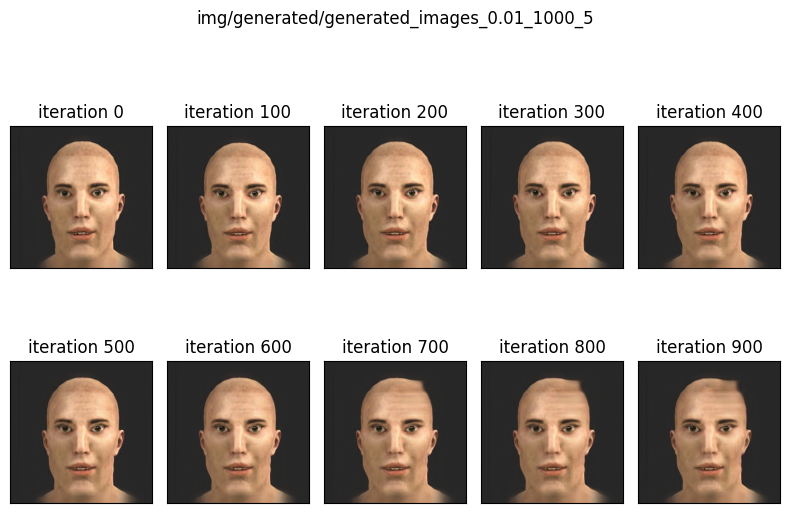

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


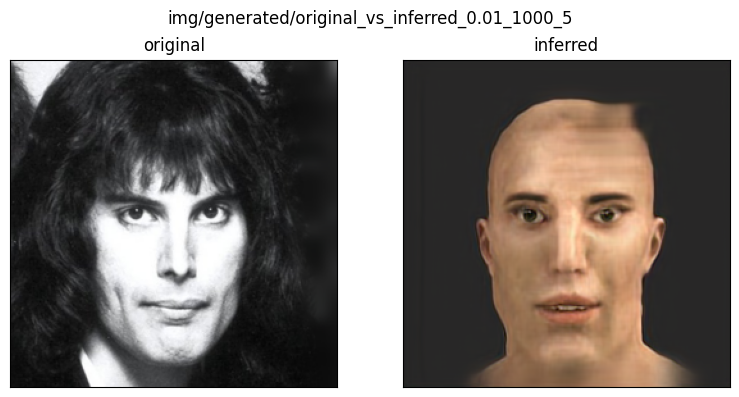

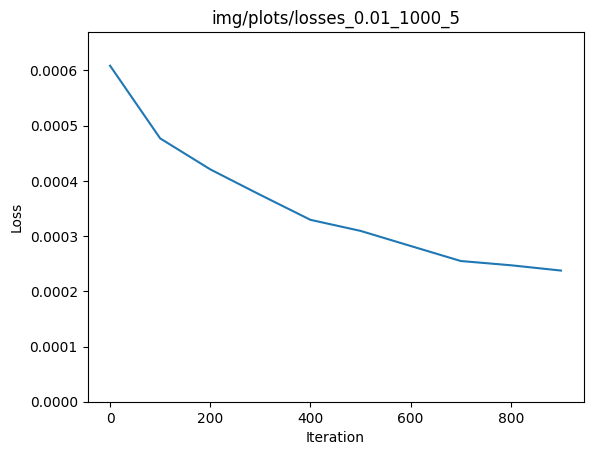

In [29]:
real_freddie_image = prep_image(TARGET_IMG_PATHS[5])

real_z, real_checkpoints, real_losses = find_z(real_freddie_image, lr=1e-2, iters=1000)

present_results(real_z, real_checkpoints, real_losses, real_freddie_image, lr=1e-2, iter=1000, number=5)

## Pix to pix MSE

In [20]:
class DifferentiablePixToPix(torch.nn.Module):
    def __init__(self, generator):
        super().__init__()
        self.z = torch.nn.Parameter(torch.randn( (1, LATENT_DIM), requires_grad=True, device="cuda"))
        
        self.generator = generator
        self.generator.eval()
        
        for p in self.generator.parameters():
            p.requires_grad = False
        
        
    def forward(self):
        return self.generator(self.z)
    
    def get_z(self):
        return self.z
    
    def print_are_training(self):
        print("Are training:")
        print(f"Generator: {self.generator.training}")
        print(f"Model: {self.training}")
        
 
 
def find_z_pix2pix(image: torch.Tensor, lr=1e-3, iters=500) -> torch.Tensor:   
    generator = import_generator(MODEL_PATH).to("cuda:0")

    model = DifferentiablePixToPix(generator)
    checkpoint_every = iters // 10

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    y_target = image.unsqueeze(0).detach()
    
    checkpoints = []
    losses = []
    for i in range(iters):
        y_pred = model()
        loss = criterion(y_target, y_pred)
        if i % checkpoint_every  == 0:
            checkpoints.append((i, model.generator(model.z)[0].detach().permute((1,2,0)).cpu().numpy()))
            losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Iteration: {i}, loss: {loss.item():.2E}")
        
    model.print_are_training()
    
    return model.get_z(), checkpoints, losses

Iteration: 0, loss: 3.16E-03
Iteration: 1, loss: 3.14E-03
Iteration: 2, loss: 3.12E-03
Iteration: 3, loss: 3.10E-03
Iteration: 4, loss: 3.09E-03
Iteration: 5, loss: 3.06E-03
Iteration: 6, loss: 3.05E-03
Iteration: 7, loss: 3.02E-03
Iteration: 8, loss: 3.01E-03
Iteration: 9, loss: 2.99E-03
Iteration: 10, loss: 2.97E-03
Iteration: 11, loss: 2.95E-03
Iteration: 12, loss: 2.94E-03
Iteration: 13, loss: 2.92E-03
Iteration: 14, loss: 2.91E-03
Iteration: 15, loss: 2.89E-03
Iteration: 16, loss: 2.87E-03
Iteration: 17, loss: 2.86E-03
Iteration: 18, loss: 2.84E-03
Iteration: 19, loss: 2.83E-03
Iteration: 20, loss: 2.82E-03
Iteration: 21, loss: 2.80E-03
Iteration: 22, loss: 2.79E-03
Iteration: 23, loss: 2.77E-03
Iteration: 24, loss: 2.77E-03
Iteration: 25, loss: 2.75E-03
Iteration: 26, loss: 2.74E-03
Iteration: 27, loss: 2.72E-03
Iteration: 28, loss: 2.72E-03
Iteration: 29, loss: 2.70E-03
Iteration: 30, loss: 2.69E-03
Iteration: 31, loss: 2.68E-03
Iteration: 32, loss: 2.67E-03
Iteration: 33, loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

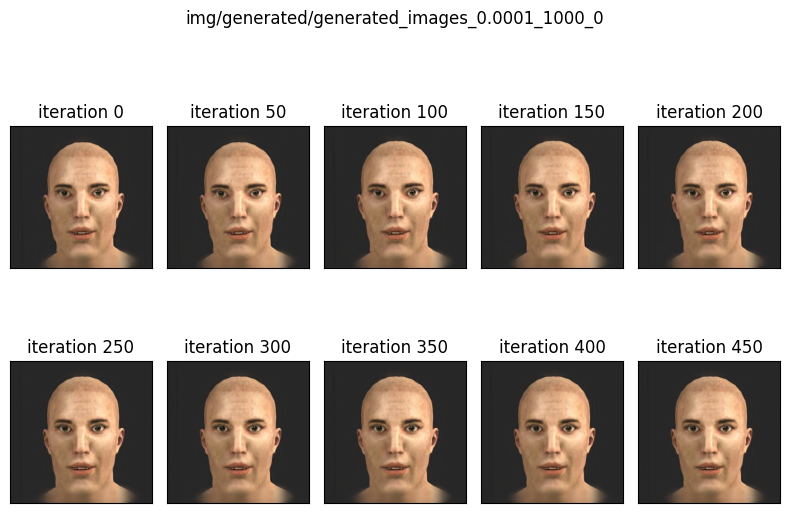

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


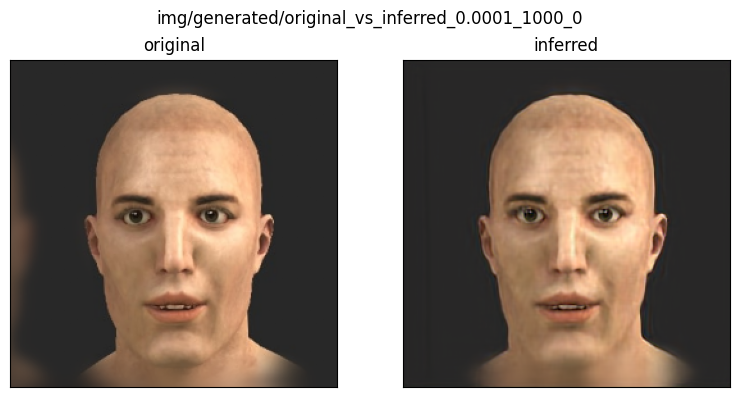

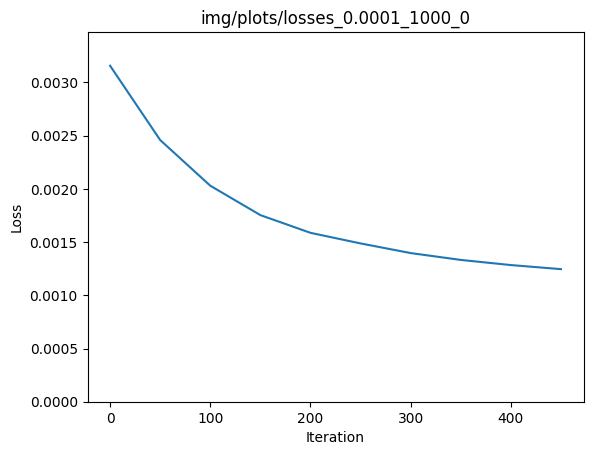

In [24]:
middle_image = prep_image(TARGET_IMG_PATHS[0])

middle_z_pix, middle_checkpoints_pix, middle_losses_pix = find_z_pix2pix(middle_image)

present_results(middle_z_pix, middle_checkpoints_pix, middle_losses_pix, middle_image)

Iteration: 0, loss: 2.81E-03
Iteration: 1, loss: 2.77E-03
Iteration: 2, loss: 2.74E-03
Iteration: 3, loss: 2.71E-03
Iteration: 4, loss: 2.69E-03
Iteration: 5, loss: 2.65E-03
Iteration: 6, loss: 2.62E-03
Iteration: 7, loss: 2.60E-03
Iteration: 8, loss: 2.56E-03
Iteration: 9, loss: 2.53E-03
Iteration: 10, loss: 2.50E-03
Iteration: 11, loss: 2.47E-03
Iteration: 12, loss: 2.43E-03
Iteration: 13, loss: 2.40E-03
Iteration: 14, loss: 2.37E-03
Iteration: 15, loss: 2.34E-03
Iteration: 16, loss: 2.31E-03
Iteration: 17, loss: 2.27E-03
Iteration: 18, loss: 2.24E-03
Iteration: 19, loss: 2.21E-03
Iteration: 20, loss: 2.18E-03
Iteration: 21, loss: 2.15E-03
Iteration: 22, loss: 2.12E-03
Iteration: 23, loss: 2.08E-03
Iteration: 24, loss: 2.06E-03
Iteration: 25, loss: 2.03E-03
Iteration: 26, loss: 1.99E-03
Iteration: 27, loss: 1.97E-03
Iteration: 28, loss: 1.93E-03
Iteration: 29, loss: 1.90E-03
Iteration: 30, loss: 1.88E-03
Iteration: 31, loss: 1.85E-03
Iteration: 32, loss: 1.82E-03
Iteration: 33, loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

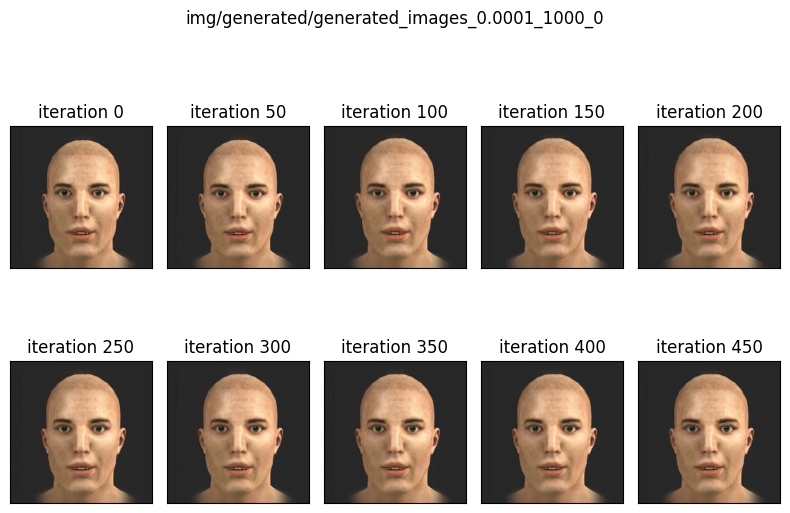

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


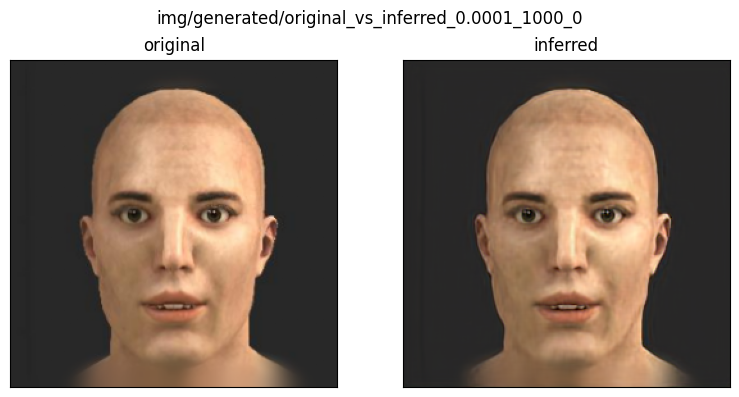

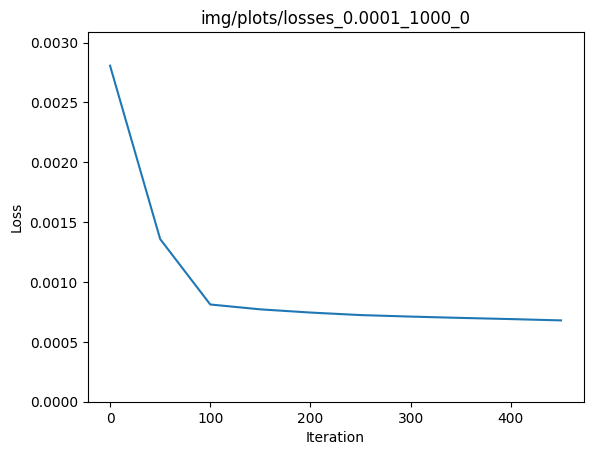

In [22]:
ingame_image = prep_image(TARGET_IMG_PATHS[1])

ingame_z_pix, ingame_checkpoints_pix, ingame_losses_pix = find_z_pix2pix(ingame_image)

present_results(ingame_z_pix, ingame_checkpoints_pix, ingame_losses_pix, ingame_image)

Iteration: 0, loss: 1.99E-01
Iteration: 1, loss: 1.99E-01
Iteration: 2, loss: 1.99E-01
Iteration: 3, loss: 1.99E-01
Iteration: 4, loss: 1.99E-01
Iteration: 5, loss: 1.99E-01
Iteration: 6, loss: 1.99E-01
Iteration: 7, loss: 1.99E-01
Iteration: 8, loss: 1.99E-01
Iteration: 9, loss: 1.99E-01
Iteration: 10, loss: 1.99E-01
Iteration: 11, loss: 1.99E-01
Iteration: 12, loss: 1.99E-01
Iteration: 13, loss: 1.99E-01
Iteration: 14, loss: 1.98E-01
Iteration: 15, loss: 1.98E-01
Iteration: 16, loss: 1.98E-01
Iteration: 17, loss: 1.98E-01
Iteration: 18, loss: 1.98E-01
Iteration: 19, loss: 1.98E-01
Iteration: 20, loss: 1.98E-01
Iteration: 21, loss: 1.98E-01
Iteration: 22, loss: 1.98E-01
Iteration: 23, loss: 1.98E-01
Iteration: 24, loss: 1.98E-01
Iteration: 25, loss: 1.98E-01
Iteration: 26, loss: 1.98E-01
Iteration: 27, loss: 1.98E-01
Iteration: 28, loss: 1.98E-01
Iteration: 29, loss: 1.98E-01
Iteration: 30, loss: 1.98E-01
Iteration: 31, loss: 1.98E-01
Iteration: 32, loss: 1.98E-01
Iteration: 33, loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

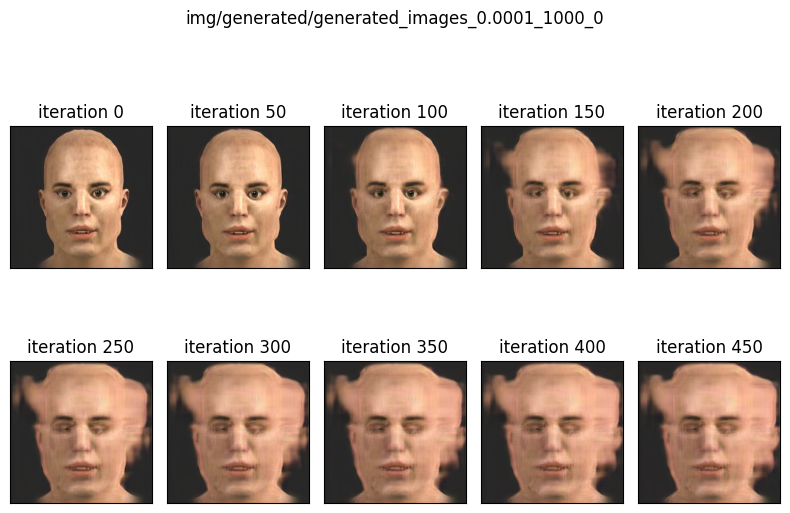

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


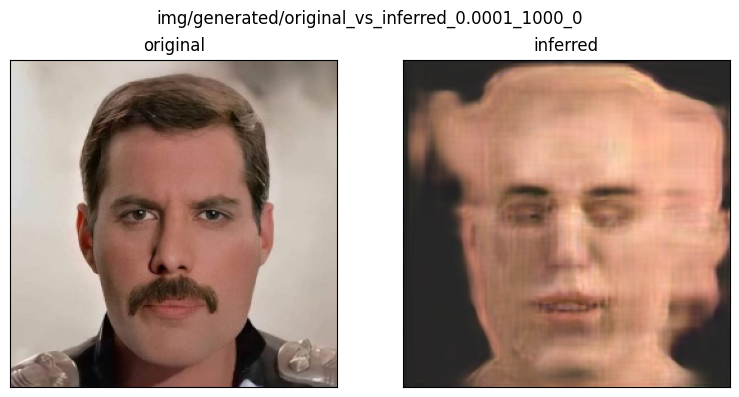

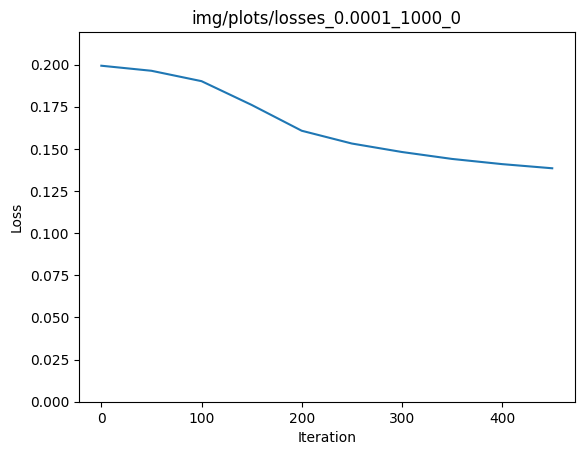

In [23]:
real_image = prep_image(TARGET_IMG_PATHS[2])

realz_pix, realcheckpoints_pix, reallosses_pix = find_z_pix2pix(real_image)

present_results(realz_pix, realcheckpoints_pix, reallosses_pix, real_image)

## Masked MSE

In [ ]:
LM_EYES = (36, 48)
LM_CHIN = (0, 17)
LM_TOTAL = 68

class DifferentiableLandmarksMasked(torch.nn.Module):
    def __init__(self, generator, landmarks_model):
        super().__init__()
        self.z = torch.nn.Parameter(torch.randn( (1, LATENT_DIM), requires_grad=True, device="cuda"))
        
        self.landmarks_model = landmarks_model
        self.generator = generator
        self.generator.eval()
        self.landmarks_model.eval()
        self.mask = torch.zeros((1, LM_TOTAL, 64, 64), device="cuda") 
        for i in range(*LM_CHIN):
            self.mask[0, i] = 1
        for i in range(*LM_EYES):
            self.mask[0, i] = 1
        
        for p in self.generator.parameters():
            p.requires_grad = False
            
        for p in self.landmarks_model.parameters():
            p.requires_grad = False
        
        
    def forward(self):
        return self.landmarks_model(self.generator(self.z)) * self.mask
    
    def get_z(self):
        return self.z.clone().detach()
    
    def print_are_training(self):
        print("Are training:")
        print(f"Generator: {self.generator.training}")
        print(f"Landmarks: {self.landmarks_model.training}")
        print(f"Model: {self.training}")
        
 
 
def find_z_masked(image: torch.Tensor, lr=1e-2, iters=500) -> torch.Tensor:   
    generator = import_generator(MODEL_PATH).to("cuda:0")
    landmarks_model = load_landmarks_model()

    model = DifferentiableLandmarksMasked(generator, landmarks_model)
    mask = model.mask
    checkpoint_every = iters // 10

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    y_target = landmarks_model(image.unsqueeze(0)).detach() 
    y_target *= mask
    
    checkpoints = []
    landmark_checkpoints = []
    losses = []
    for i in range(iters):
        y_pred = model()
        loss = criterion(y_target, y_pred)
        if i % checkpoint_every  == 0:
            optimizer.
            checkpoints.append((i, model.generator(model.z)[0].detach().permute((1,2,0)).cpu().numpy()))
            landmark_checkpoints.append((i, softargmax2d(y_pred[0]).detach().cpu().numpy()))
            losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Iteration: {i}, loss: {loss.item():.2E}")
        
    model.print_are_training()
    
    return  model.get_z(), checkpoints, losses

In [ ]:
real_freddie_image = prep_image(TARGET_IMG_PATHS[5])

real_z, real_checkpoints, real_losses = find_z_masked(real_freddie_image, lr=1e-2, iters=1000)

present_results(real_z, real_checkpoints, real_losses, real_freddie_image, lr=1e-2, iter=1000, number=5)

In [ ]:
for image in TARGET_IMG_PATHS:
    real_image = prep_image(image)
    real_z, real_checkpoints, real_losses = find_z_masked(real_image, lr=1e-2, iters=1000)
    present_results(real_z, real_checkpoints, real_losses, real_image, lr=1e-2, iter=1000, number=5)

In [ ]:
for image in TARGET_IMG_PATHS:
    real_image = prep_image(image)
    real_z, real_checkpoints, real_losses = find_z_masked(real_image, lr=1e-3, iters=1000)
    present_results(real_z, real_checkpoints, real_losses, real_image, lr=1e-3, iter=1000, number=5)

### ... kiedyś się kurde uda



In [ ]:
from tqdm import tqdm

def make_an_attempt(lr, iters, number):
    real_image = prep_image(TARGET_IMG_PATHS[2])
    z_init, z, checkpoints, _, losses = find_z(real_image, lr=lr, iters=iters)

    present_results(z, checkpoints, losses, real_image, lr, iters, number)
    torch.save(z, f"z/real_freddie_{lr}_{iters}_{number}.pt")
    torch.save(z_init, f"z_init/real_freddie_{lr}_{iters}_{number}.pt")
    save_image(generator(z)[0], f"img/generated/real_freddie_{lr}_{iters}_{number}.jpg")
    return losses
    

lr_res = []
for lr in tqdm([1e-4, 1e-3, 1e-2]):
    print(f"-----LEARNING RATE: {lr}-----")
    iters_res = []
    for iters in (2500,):
        print(f"----------ITERS---: {iters}")
        losses_res = []
        for i in range(10):
            print(f"-------------------  ATTEMPT: {i + 1}")
            losses = make_an_attempt(lr, iters, i)
            losses.append(losses)
        iters_res.append(losses_res)
    lr_res.append(iters_res)
nd

with open('losses.npy', 'wb') as f:
    np.save(f, np.array(lr_res))

## Wasserstein distance

In [ ]:
from geomloss import SamplesLoss

def wasserstein_distance(y_pred, y_target):
    loss = SamplesLoss("sinkhorn", p=2, blur=0.05)
    a = y_pred.squeeze(0)
    b = y_target.squeeze(0)
    return sum([loss(a_i, b_i) for a_i, b_i in zip(a, b)])

In [ ]:
a = torch.full((1, 68, 64, 64), 0.7)
b = torch.full((1, 68, 64, 64), 0.5)

wasserstein_distance(a,b)

In [ ]:
def find_z_emd(image: torch.Tensor, lr=1e-3, iters=500) -> torch.Tensor:   
    generator = import_generator(MODEL_PATH).to("cuda:0")
    landmarks_model = load_landmarks_model()

    model = DifferentiableLandmarks(generator, landmarks_model)
    checkpoint_every = iters // 10

    criterion = wasserstein_distance
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    y_target = landmarks_model(image.unsqueeze(0)).detach()
    
    checkpoints = []
    landmark_checkpoints = []
    losses = []
    for i in range(iters):
        y_pred = model()
        loss = criterion(y_pred=y_pred, y_target=y_target)
        if i % checkpoint_every  == 0:
            checkpoints.append((i, model.generator(model.z)[0].detach().permute((1,2,0)).cpu().numpy()))
            landmark_checkpoints.append((i, softargmax2d(y_pred[0]).detach().cpu().numpy()))
            losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Iteration: {i}, loss: {loss.item():.2E}")
        
    model.print_are_training()
    
    return  model.get_z(), checkpoints, losses

In [ ]:
middle_image = prep_image(TARGET_IMG_PATHS[1])

mid_z, mid_checkpoints, mid_losses = find_z_emd(middle_image, lr=1e-3, iters=1000)

present_results(mid_z, mid_checkpoints, mid_losses, middle_image, lr=1e-3, iter=1000, number=1)



In [ ]:
middle_image = prep_image(TARGET_IMG_PATHS[0])

mid_z, mid_checkpoints, mid_losses = find_z_emd(middle_image, lr=1e-3, iters=1000)

present_results(mid_z, mid_checkpoints, mid_losses, middle_image, lr=1e-3, iter=1000, number=1)